# Basic statistical techniques and unsupervised learning

1. Statistical Learning<br>
    1.1 Stochastic Gradient Descent

2. Clustering<br>
    2.1 K-Means clustering<br>
    2.2 Self-organizing maps<br>
    
2. Dimensionality reduction<br>
    2.1 PCA for data visualization<br>
    2.2 PCA for data pre-processing<br>
    2.3 PCA for simpler supervised-learning

### Import Python packages
Fortunately a lot of common data science tools are freely available in the python ecosystem (look at PyPi for details). Scikit-learn is a great place to start. We can use `matplotlib` and `seaborn` for plotting data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import IPython.display as ipydis
import time

import numpy as np
import pandas as pd

import sklearn
from sklearn import datasets # Cancer dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Data preprocessors
from sklearn.cluster import KMeans

# set random seed for reproducibility
seed=42

### Custom utility functions

In [2]:
def load_cancer_data():
  """ Return cancer dataset (unscaled).
  Returns:
      X, Y
  """
  # Load data
  from sklearn import datasets
  data = datasets.load_breast_cancer()

  # Get features and target
  X = pd.DataFrame(data['data'], columns=data['feature_names'])
  X = X[sorted(X.columns)]
  Y = data['target']
  return X, Y

def plot_kmeans_obj(X, tot_clusters=10, plot_points=True):
  opt_obj_vec = []
  for k in range(1, tot_clusters):
    model = KMeans(n_clusters=k)  
    model.fit(X)
    labels = model.labels_
    centers = model.cluster_centers_
    if plot_points:
      plot_kmeans_points(X,centers,labels)
    opt_obj_vec.append(model.inertia_/X.shape[0])

  # Plot
  k = np.arange(len(opt_obj_vec)) + 1

  plt.figure(figsize=(8,6),dpi=80)
  plt.plot(k, opt_obj_vec, '--o')
  plt.xlabel('Number of clusters (k)', fontsize=14)
  plt.ylabel('Inertia', fontsize=14)
  plt.grid(True)

  return opt_obj_vec

def plot_kmeans_points(X,centers,labels):
  plt.figure(figsize=(7, 7))
  plt.scatter(X[:, 0], X[:, 1], edgecolor=None, alpha=0.4, c=labels);
  plt.scatter(centers[:,0],centers[:,1],marker="*",s=100)

  plt.title('2-D dataset (clustered with k-means)', fontsize=14)
  plt.xlabel('X0', fontsize=14)
  plt.ylabel('X1', fontsize=14)
  plt.grid(True)
  plt.show()
  
def create_run_blob_kmeans(n_samples,n_features,n_clusters):
  # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
  X, y = datasets.make_blobs(n_samples = n_samples,
                            n_features = n_features,
                            centers = n_clusters,
                            random_state = seed)
  # Normalize features
  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
  X_sc = StandardScaler().fit_transform(X)

  model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=seed, n_jobs=4)
  model.fit(X_sc);

  plot_kmeans_obj(X_sc,20)
  
def plot_hists(k_means_bins, y_bins, x_labels = ['Malignant', 'Benign']):
  """ Specific function to plot histograms from bins.
  matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
  """
  x = np.arange(len(x_labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, y_bins, width, label='True label')
  rects2 = ax.bar(x + width/2, k_means_bins, width, label='K-means')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Total count')
  ax.set_title('Histogram')
  ax.set_xticks(x)
  ax.set_xticklabels(x_labels)
  ax.set_ylim(0, 450)

  def autolabel(rects):
    """ Attach a text label above each bar in *rects*, displaying its height. """
    for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

  ax.legend(loc='best')

  autolabel(rects1)
  autolabel(rects2)
  fig.tight_layout()
  plt.show()

# 1. Statistical Learning: Line Fitting

You are likely familiar with statistical learning in the form of linear regression so let's work through how we can fit linear data using a common learning method called [Stocastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD). SGD is a common method used in training deep neural networks. Here we will use it to fit linear data.

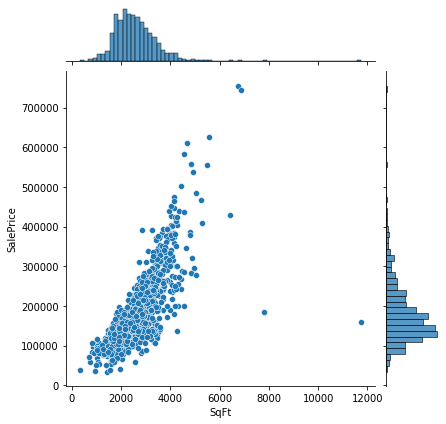

In [3]:
# load realestate sales data from Kaggle:
#   https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview
df = pd.read_csv('realestate_train.csv')
# extract total home square footage
area = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]
area.name = 'SqFt'
# and sale price
price = df["SalePrice"]

plot = sns.jointplot(x=area, y=price)
plt.show()

The Data is nicely correlated as you might expect. Let's fit it with a line so we can estimate future sale prices based on home size. We'll assume our predition function is linear with a slope and a fixed zero intercept since no house size should be equal to zero sale price.

In [4]:
def predict_price(linear_slope,input_area):
  return linear_slope * input_area

Now we need a way to evaluate how well our prediction fits the data and [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) is a common method used for our type of problem.

![MSE_eqn](mse.svg)

In [5]:
def evaluate(linear_slope,input_area,true_price):
  price_prediction = predict_price(linear_slope,input_area)
  MSE = np.mean((true_price - price_prediction)**2) / np.prod(true_price.shape)
  return MSE

Our prediction will be based on a `linear_slope` that will be chosen at random at first, and we need to use our SGD to update it iteratively so it approaches the best value (the value that minimizes MSE). SGD uses this update policy:
![sgd_eqn](sgd.svg)
where in our case `w` is the slope we want to update and $\eta$ is called the "learning rate," and `Q(w)` is our prediction function. In our case this functionally looks like this:

In [6]:
def learn(input_area,input_price,input_slope,learning_rate=0.000001):
  # first we need df/dx where f = predict_price and x = input_size
  df_dx = np.mean((predict_price(input_slope,input_area) - input_price))
  # now we update the slope 
  new_slope = input_slope - learning_rate * df_dx  # SGD update step
  return new_slope

Each application of the `learn` function updates the slope and the `learning_rate` dampens that update. This iterative method helps one find the value that minimizes the `df_dx`, or gradient, as shown here.

![sgd_example](sgd_example.png)

[image reference](https://www.researchgate.net/publication/331758559_Synergy_of_physics-based_reasoning_and_machine_learning_in_biomedical_applications_Towards_unlimited_deep_learning_with_limited_data)

The `learning_rate` is shown as driving how big of steps you take around the minimum. If your `learning_rate` is too large, you may miss the minimum, if it is too small you may never reach the minimum.

Putting it all together we can iterate to a solution:

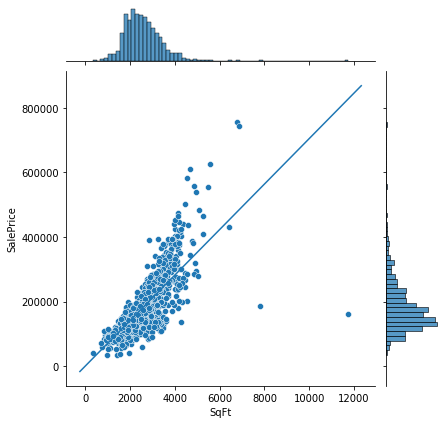

Step:  49   Loss: 1688606.43975  Current Slope:   70.47826


In [7]:
m = 1
learning_rate = 0.0001  # play with this value
print ("Initial slope: ", m)
for i in range(0, 50):
  # all the magic here
  m = learn(area,price,m,learning_rate)
  
  # plot output so we can see progress
  ipydis.clear_output('wait')
  plot = sns.jointplot(x=area, y=price)
  xline = np.linspace(plot.ax_joint.axes.get_xlim()[0],plot.ax_joint.axes.get_xlim()[1],1000)
  yline = m*xline
  plot.ax_joint.plot(xline,yline)
  plt.show()
  print ("Step: %3d   Loss: %10.5f  Current Slope: %10.5f" % (i,evaluate(m,area,price), m))
  time.sleep(0.5)

# 2. Clustering Data
Our objective is to segregate the dataset into discrete components representing low-dimensional structures that are not immediately visible. We will demonstrate this, first, on a toy dataset that we _design_ to have a lower inherent dimensionality.

### Toy dataset (2-D blobs)
Define 3 blobs of data on a 2D plane

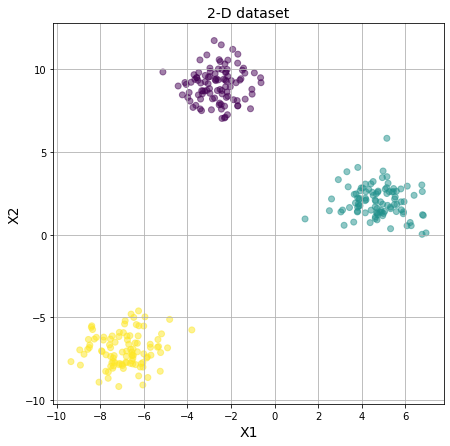

In [8]:
n_samples = 300 # 300 2D data points
n_features = 2  # 2D data
n_clusters = 3  # 3 unique blobs

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
X, Y = datasets.make_blobs(n_samples = n_samples,
                           n_features = n_features,
                           centers = n_clusters,
                           random_state = seed)
# Returns:
# X.shape = (n_samples, n_features)
# The generated samples.

# Y.shape = (n_samples,)
# The integer labels for cluster membership of each sample.

# plot data points
plt.figure(figsize=(7, 7))
plt.scatter(X[:,0],X[:,1], edgecolor=None, alpha=0.5, c=Y);

plt.title('2-D dataset', fontsize=14)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.grid(True)

Normalize features

In [9]:
# Normalize features
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
X_sc = StandardScaler().fit_transform(X)

Plot them 

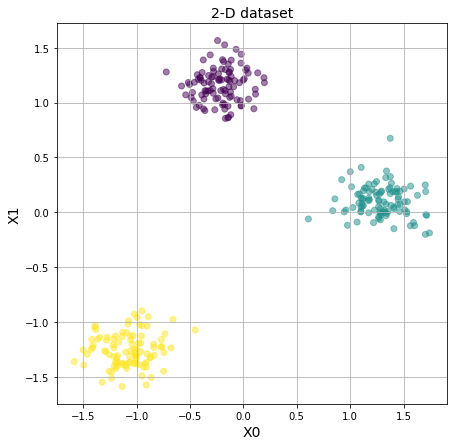

In [10]:
plt.figure(figsize=(7, 7))
plt.scatter(X_sc[:, 0], X_sc[:, 1], edgecolor=None, alpha=0.5, c=Y);

plt.title('2-D dataset', fontsize=14)
plt.xlabel('X0', fontsize=14)
plt.ylabel('X1', fontsize=14)
plt.grid(True)

## 1.1 K-means Clustering

K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

![image](kmeans.png)

Figure courtesy of [kmeans wikipedia](https://en.wikipedia.org/wiki/K-means_clustering) page.

### Step 1: Pick random starting centroids from data

In [11]:
# inputs:
#   X: data of shape (N-points,N-features)
#   n_clusters: number of clusters being used
#   seed: random number seed
# outputs:
#   centroids: randomly chosen from the data
#           with shape (N-clusters,N-features)
def initialize_centroids(X,n_clusters,seed=123):
  # set random seed
  np.random.RandomState(seed)
  # randomize the data point indices
  random_idx = np.random.permutation(X.shape[0])
  # pick the first three indices from the random list
  # these will be our initial centroids
  centroids = X[random_idx[:n_clusters]] # (N-clusters,2)
  return centroids

### Step 2a: Calculate distance to each centroid

In [12]:
# inputs:
#   X: data of shape (N-points,N-features)
#   n_clusters: number of clusters being used
#   centroids: cluster centroids
#           with shape (N-clusters,N-features)
# outputs:
#   distance: distance of each point to each
#           centroid with shape (N-points,N-clusters)
def compute_distance(X, centroids, n_clusters):
  # distance vector
  distance = np.zeros((X.shape[0], n_clusters))
  # loop over each centroid
  for k in range(n_clusters):
    # calculate distance for each point from centroid
    kcentroid_distance = X - centroids[k, :]
    # apply normalization for stability
    row_norm = np.linalg.norm(kcentroid_distance, axis=1)
    # return distance squared
    distance[:, k] = np.square(row_norm)
  return distance

### Step 2b: Find nearest cluster for each point

In [13]:
# inputs:
#   distance: distance of each point to each
#           centroid with shape (N-points,N-clusters)
# outputs:
#   nearest_centroid_indices: index of nearest centroid
#           with shape (N-points)
def find_closest_centroid(distance):
  nearest_centroid_indices = np.argmin(distance, axis=1)
  return nearest_centroid_indices

### Step 3: Calculate new centroids

In [14]:
# inputs:
#   X: data of shape (N-points,N-features)
#   nearest_centroid_indices: index of nearest centroid
#           with shape (N-points)
#   n_clusters: number of clusters being used
# outputs:
#   centroids: cluster centroids
#           with shape (N-clusters,N-features)
def compute_centroids(X, nearest_centroid_indices, n_clusters):
  # new centroids vector
  centroids = np.zeros((n_clusters, X.shape[1]))
  # loop over each centroids
  for k in range(n_clusters):
    # calculate the mean of all points assigned to this centroid
    centroids[k, :] = np.mean(X[nearest_centroid_indices == k, :], axis=0)
  return centroids

### Putting it all together

In [15]:

def apply_kmeans(X, n_clusters, iterations = 100, seed = 123):
  # initialize centroids
  centroids = initialize_centroids(X,n_clusters,seed) # shape: (N-clusters,N-features)
  
  # for each loop, we'll iteratively improve our centroid locations
  for i in range(iterations):
    # save old centroids
    old_centroids = centroids
    # compute the distances of each point X to each centroid
    distance = compute_distance(X, old_centroids, n_clusters)  # shape: (N-points,N-clusters)
    # return the clostest cluster (0,1, or 2) for each point 
    cluster_id = find_closest_centroid(distance)  # shape: (N-points)
    # calculate the mean position of each labeled cluster
    centroids = compute_centroids(X, cluster_id, n_clusters)  # shape: (N-clusters,N-features)
    
    # plotting for visual comprehension
    ipydis.clear_output('wait')
    print('iteration: %d' % i)
    plot_kmeans_points(X,centroids,cluster_id)
    time.sleep(0.5)
    
    # if our points are the same as the old centroids, then we can stop
    if np.all(old_centroids == centroids):
      break
  
  return centroids,cluster_id


def plot_kmeans_points(X,centroids,nearest_centroid):
  plt.figure(figsize=(7, 7))
  plt.scatter(X[:, 0], X[:, 1], edgecolor=None, alpha=0.4, c=nearest_centroid);
  plt.scatter(centroids[:,0],centroids[:,1],marker="*",s=100)

  plt.title('2-D dataset (clustered with k-means)', fontsize=14)
  plt.xlabel('X0', fontsize=14)
  plt.ylabel('X1', fontsize=14)
  plt.grid(True)
  plt.show()

### Run example:

iteration: 4


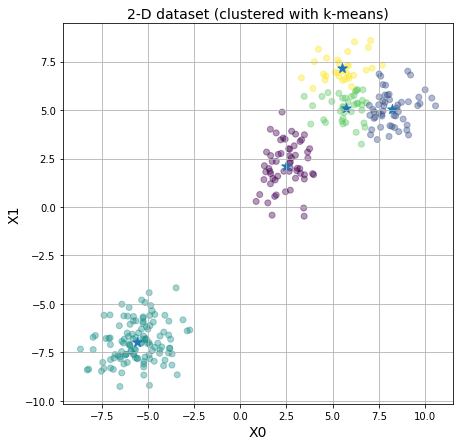

(array([[ 2.4650625 ,  2.130786  ],
        [ 8.23030921,  5.06731669],
        [-5.57676553, -6.96237766],
        [ 5.7098291 ,  5.11516179],
        [ 5.53530776,  7.15700147]]),
 array([4, 2, 2, 2, 2, 2, 0, 2, 1, 2, 4, 3, 2, 2, 1, 2, 2, 3, 2, 1, 2, 2,
        2, 3, 2, 1, 0, 2, 2, 4, 1, 2, 0, 2, 3, 3, 1, 0, 0, 2, 1, 2, 2, 4,
        0, 3, 3, 3, 1, 1, 0, 3, 1, 0, 1, 0, 2, 3, 2, 0, 4, 3, 1, 0, 3, 2,
        1, 2, 2, 3, 2, 0, 2, 3, 2, 1, 2, 1, 0, 4, 4, 3, 2, 2, 3, 4, 0, 2,
        1, 0, 1, 2, 2, 0, 0, 0, 3, 3, 0, 1, 0, 0, 3, 1, 3, 4, 2, 2, 1, 2,
        4, 2, 4, 4, 2, 0, 1, 3, 2, 0, 4, 1, 2, 1, 0, 0, 2, 2, 0, 0, 1, 1,
        2, 3, 0, 1, 3, 0, 0, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 3, 0, 2, 2,
        2, 2, 2, 4, 2, 3, 1, 2, 4, 2, 2, 0, 2, 3, 2, 0, 4, 2, 4, 3, 2, 3,
        2, 2, 0, 2, 0, 2, 3, 4, 4, 2, 1, 2, 0, 2, 3, 0, 2, 4, 0, 4, 2, 2,
        2, 1, 3, 4, 2, 4, 2, 2, 0, 1, 2, 2, 1, 2, 2, 4, 2, 0, 2, 1, 4, 2,
        2, 2, 0, 0, 2, 0, 1, 3, 2, 0, 4, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 1,
    

In [16]:
n_samples  = 300 # 300 2D data points
n_features = 2   # 2D data
n_clusters = 5   # unique blobs
seed       = 456
iterations = 25

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
X, Y = datasets.make_blobs(n_samples = n_samples,
                           n_features = n_features,
                           centers = n_clusters,
                           random_state = seed)

apply_kmeans(X,n_clusters,iterations,seed)

### Breast cancer dataset

In [17]:
data = datasets.load_breast_cancer()
print(type(data))  # dictionary-like object
print(data.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


Details of the data can be found here:

In [18]:
# print(data['DESCR'])

Get features and targets

In [19]:
# wrap data in pandas DataFrame
X = data['data']
Y = data['target'] # value: 0 = 'Malignant' 1 = 'Benign'

print(X.shape)
print(Y.shape)

(569, 30)
(569,)


Lets peek at the data

In [20]:
print(pd.DataFrame(X, columns=data['feature_names']))
print(Y)  # value: 0 = 'Malignant' 1 = 'Benign'
print(np.bincount(Y))

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

Scale features

In [21]:
# normalize
X_sc = StandardScaler().fit_transform(X)

Define K-means model and train, this time we'll just use the one from scikit-learn library.

In [22]:
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans.fit(X_sc);

In [23]:
print(kmeans.labels_)  # value 0-1 since we defined 2 clusters
print(np.bincount(kmeans.labels_)) 

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

Plot histogram of true class labels (malignant/benign) and cluster labels

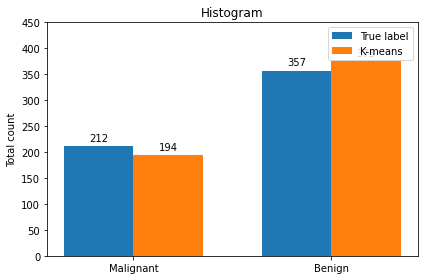

In [24]:
k_means_bins = np.bincount(kmeans.labels_)
y_bins = np.bincount(Y)
plot_hists(k_means_bins, y_bins, x_labels=['Malignant', 'Benign'])

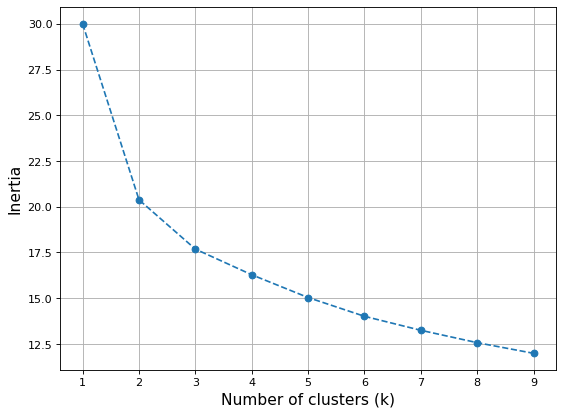

In [25]:
plot_kmeans_obj(X_sc, tot_clusters=10, plot_points=False);

### Beware
In this case - we knew that 2 clusters (benign or malignant) were appropriate for our model. YMMV.

## 1.2 [Self-organizing maps](https://en.wikipedia.org/wiki/Self-organizing_map)

Some of the concepts date back further, but SOMs were proposed and became widespread in the 1980s, by a Finnish professor named Teuvo Kohonen and are also called 'Kohonen maps'.

The idea behind a SOM is that you’re mapping high-dimensional vectors onto a smaller dimensional (typically 2D) space. Vectors that are close in the high-dimensional space also end up being mapped to nodes that are close in 2D space thus preserving the "topology" of the original data.

Helper functions:

In [26]:
# finding best matching unit
def find_bmu(t, net, n):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(n, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(n, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

# Decaying radius of influence 
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

# Decaying learning rate
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

# Influence in 2D space
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

# Update weights
def update_weights(net,bmu_idx,r,l):
    wlen = net.shape[2]
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(wlen, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, wlen)
    return net

### Generating "Color" data and normalizing

In [27]:
raw_data = np.random.randint(0, 255, (200, 3))
data = StandardScaler().fit_transform(raw_data)

### Defining SOM 
Defining network size, number of iterations and learning rate

In [28]:
network_dimensions = np.array([5, 5])
n_iterations = 2000
init_learning_rate = 0.01

Establish size variables based on data

In [29]:
m = data.shape[0]
n = data.shape[1]

Weight matrix (i.e. the SOM) needs to be one n-dimensional vector for each neuron in the SOM

In [30]:
net = np.random.random((network_dimensions[0], network_dimensions[1], n)) # 25 neurons each with a 3D vector

Initial neighbourhood radius and decay parameter

In [31]:
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
time_constant = n_iterations / np.log(init_radius)

### Initial state of SOM color network

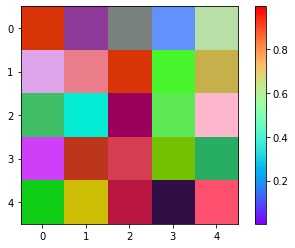

In [32]:
plt.imshow(net,cmap='rainbow')
plt.colorbar()
plt.show()

### Training SOM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


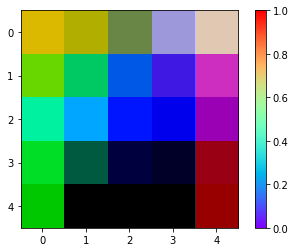

In [33]:
for iteration in range(n_iterations):
    # select a training example at random - shape of 1x3
    t = data[np.random.randint(0, m),:].reshape(np.array([n, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n) # Gives the row, column of the best neuron
    # decay the SOM parameters
    r = decay_radius(init_radius, iteration, time_constant)
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    # Update SOM weights
    net = update_weights(net,bmu_idx,r,l)
    if iteration % 100 == 0:
      ipydis.clear_output('wait')
      plt.imshow(net,cmap='rainbow')
      plt.colorbar()
      plt.show()
      time.sleep(0.5)

### Visualization of trained colormap SOM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


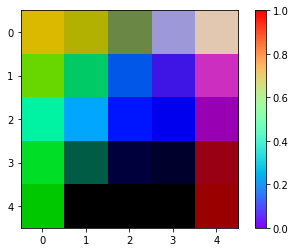

In [34]:
plt.imshow(net, interpolation='nearest',cmap='rainbow')
plt.colorbar()
plt.show()

### 1.3.5 SOM on Cancer data

In [35]:
# Load data
data = datasets.load_breast_cancer()
# Get features and target
X = data['data'] # pd.DataFrame(data['data'], columns=data['feature_names'])
Y = data['target']
print(X.shape,Y.shape)

(569, 30) (569,)


In [36]:
network_dimensions = np.array([10, 10])
n_iterations = 4000
init_learning_rate = 0.01
# establish size variables based on data
n_points = X.shape[0] # number of points
n_features = X.shape[1] # 30 features per point

# weight matrix (i.e. the SOM) needs to be one n-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], n_features))

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

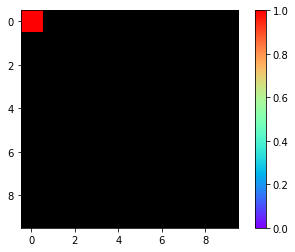

In [37]:
# convert the network to something we can visualize 
net_vis = np.zeros(shape=(net.shape[0],net.shape[1],3),dtype='double') # Array for SOM color map visualization

for sample in range(n_points):
    t = X[sample,:].reshape(np.array([n_features, 1]))
    # find its Best Matching Unit for this data point
    bmu, bmu_idx = find_bmu(t, net, n_features)
    # set that unit to the label of this data point
    net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign

plt.imshow(net_vis,cmap='rainbow')
plt.colorbar()
plt.show()

### Training SOM on Cancer data

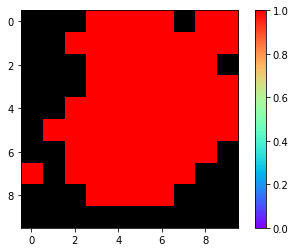

In [38]:
for iteration in range(n_iterations):
    # select a training example at random - shape of 1x3
    t = X[np.random.randint(0, n_points),:].reshape(np.array([n_features, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n_features)
    # decay the SOM parameters
    r = decay_radius(init_radius, iteration, time_constant)
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    # Update SOM weights
    net = update_weights(net,bmu_idx,r,l)

    if iteration % 100 == 0:
      ipydis.clear_output('wait')
      net_vis = np.zeros(shape=(np.shape(net)[0],np.shape(net)[1],3),dtype='double') # Array for SOM color map visualization

      for sample in range(n_points):
          t = X[sample,:].reshape(np.array([n_features, 1]))
          # find its Best Matching Unit
          bmu, bmu_idx = find_bmu(t, net, n_features)
          net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign
          
      plt.imshow(net_vis,cmap='rainbow')
      plt.colorbar()
      plt.show()
      time.sleep(0.5)

### Visualization of trained SOM

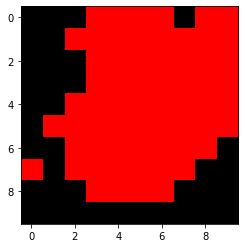

In [39]:
net_vis = np.zeros(shape=(net.shape[0],net.shape[1],3),dtype='double') # Array for SOM color map visualization

for sample in range(n_points):
    t = X[sample,:].reshape(np.array([n_features, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, n_features)
    net_vis[bmu_idx[0],bmu_idx[1],0] = Y[sample] # Red if benign
    
plt.imshow(net_vis)
plt.show()

# Keep learning

1. lagunita.stanford.edu/courses/HumanitiesSciences/StatLearning/Winter2016/course/
2. www.coursera.org/learn/ml-clustering-and-retrieval/
3. www.coursera.org/learn/machine-learning/home/week/8